<a href="https://colab.research.google.com/github/mAminl/HWs/blob/master/HW4_Q1_P2(GRU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mohammad Amin Latifi

401300966

HW4 Q1 Part2:
Ferdowsi(GRU)

Reference of the basic of the code structure is:

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    !gdown 14uWwVZ2CGW-t9VkNCS-Thb8s6T4YJRDo
    lines = open('/content/ferdousi.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    test_list = lines[2:]
    test_list1 = test_list[::2]
    test_list2 = test_list[1::2]

    pairs = list(zip(test_list1, test_list2))
    print(pairs[1])

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 14

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    # pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
      
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('Mesra1', 'Mesra2',False)
print(random.choice(pairs))

Reading lines...
Downloading...
From: https://drive.google.com/uc?id=14uWwVZ2CGW-t9VkNCS-Thb8s6T4YJRDo
To: /content/ferdousi.txt
100% 4.54M/4.54M [00:00<00:00, 255MB/s]
('خداوند نام و خداوند جای', 'خداوند روزی ده رهنمای')
Read 49608 sentence pairs
Trimmed to 49608 sentence pairs
Counting words...
Counted words:
Mesra1 12686
Mesra2 13322
('نوندی کجا بادبانش نکوست', 'به خوبی سزاوار کیخسرو اوست')


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
teacher_forcing_ratio = 1


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]        
            
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, n_epoch, print_every=1000, plot_every=10, learning_rate=1e-4):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    train_pairs = pairs[1:math.floor(len(pairs)*0.7)]
    n_iters = math.floor(len(pairs)*0.7)-1

    criterion = nn.CrossEntropyLoss()
                         
    for epoch in range(1,n_epoch+1):
        training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
        print("Epoch %d \n" % epoch)
        for iter in range(1, n_iters + 1):
            training_pair = training_pairs[iter - 1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = train(input_tensor, target_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                             iter, iter / n_iters * 100, print_loss_avg))

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs[math.floor(len(pairs)*0.7):])
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words[0])
        print('<', output_sentence)
        print('')

In [ ]:
%matplotlib inline

Epoch 1 

0m 39s (- 10m 49s) (2000 5%) 6.6288
1m 16s (- 9m 44s) (4000 11%) 6.2056
1m 52s (- 8m 59s) (6000 17%) 6.0860
2m 29s (- 8m 17s) (8000 23%) 5.9750
3m 5s (- 7m 38s) (10000 28%) 5.9443
3m 41s (- 6m 59s) (12000 34%) 5.8644
4m 17s (- 6m 21s) (14000 40%) 5.7750
4m 54s (- 5m 44s) (16000 46%) 5.7687
5m 30s (- 5m 6s) (18000 51%) 5.6880
6m 6s (- 4m 29s) (20000 57%) 5.6000
6m 42s (- 3m 52s) (22000 63%) 5.5550
7m 18s (- 3m 15s) (24000 69%) 5.5263
7m 54s (- 2m 39s) (26000 74%) 5.4832
8m 30s (- 2m 2s) (28000 80%) 5.4199
9m 6s (- 1m 26s) (30000 86%) 5.3667
9m 42s (- 0m 49s) (32000 92%) 5.3917
10m 18s (- 0m 13s) (34000 97%) 5.3358
Epoch 2 

11m 9s (- 182m 39s) (2000 5%) 7.1717
11m 46s (- 90m 24s) (4000 11%) 5.1514
12m 22s (- 59m 14s) (6000 17%) 5.2016
12m 58s (- 43m 20s) (8000 23%) 5.1042
13m 34s (- 33m 33s) (10000 28%) 5.1111
14m 10s (- 26m 50s) (12000 34%) 5.0501
14m 46s (- 21m 52s) (14000 40%) 4.9781
15m 22s (- 17m 59s) (16000 46%) 5.0255
15m 58s (- 14m 50s) (18000 51%) 4.9878
16m 34s (- 12

<Figure size 432x288 with 0 Axes>

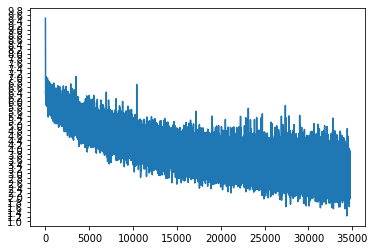

In [ ]:
hidden_size = 350
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
trainIters(encoder1, decoder1, 10, print_every=2000)

In [ ]:
evaluateRandomly(encoder1, decoder1)

> بپاسخ گشادند یکسر زبان
= که ای نامور پرهنر پهلوان
< اگر چند باشد به هر کار یار <EOS>

> ز کار جهان یکسر آگه کنید
= دلم را سوی روشنی ره کنید
< ز دیدار او را به هامون کنید <EOS>

> ورا نامور خواندی نوش زاد
= نجستی ز ناز از برش تندباد
< سواری دلاور به در دم <EOS>

> جهانجوی با آن دو خسرو پرست
= گرفت از پی و از برسم بدست
< به دست دگر دست کرده دست <EOS>

> پس اندر همی راند بهرام نرم
= برو بارگی را نکرد ایچ گرم
< یک یک هفته با او براه و گرم <EOS>

> به بندوی و گستهم گفت آن زمان
= که اکنون شدم زین سخن بدگمان
< که بر شیر بد بدگمان را گمان <EOS>

> به نرسی چنین گفت یک روز شاه
= کز ایدر برو با نگین و کلاه
< که چون او گشت با او براه <EOS>

> ازان پس به بندوی و گستهم گفت
= که بگشایم این داستان از نهفت
< که این را سر اندر نهفت <EOS>

> که برکس نماند همی زور و بخت
= نه گنج و نه دیهیم شاهی نه تخت
< نه شاهی نه تخت و نه تاج و نه تاج و نه تخت <EOS>

> خرد مرد راخلعت ایزدیست
= سزاوار خلعت نگه کن که کیست
< سیاوش ز هر دو همی <EOS>

